In [1]:
""" import useful functions """

# Generic
import pandas as pd
import numpy as np
import scipy
import sys
from itertools import islice, cycle
import math
import os
import sys
import time

# cosmology
import pyccl as ccl
import tjpcov as tjp
from tjpcov.covariance_calculator import CovarianceCalculator
from astropy.io import fits
import yaml
import sacc
import time

# Generate data sets
from sklearn.datasets import make_blobs

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Get quantities to put into MCMC

## Create mock redshift distribution (define z and output Binned_distribution(z))

In [2]:
""" Get a binned redshift distribution - defining functions """
"""This will come from the dataset we decide to test"""

# define the reasonable redshift distribution (not normalized yet)

def redshiftdist(z):
    """
    Defines a reasonable redshift distribution (not normalized yet)
    input:
        redshift z: numpy.array with dim:N
    returns:
        redshift distribution p(z): numpy.array with dim:N
    """
    alpha = 1.27
    beta = 1.02
    z0 = 0.3
    pz = z**alpha * np.exp(-(z / z0)**beta)
    return pz

def bindist(z, n_bins):
    """
    Finds redshift bins so that integral of p(z) over each bin stays the same.
    (in limit of large len(z))
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int (value M)
    returns:
        redshift bin edges: numpy.array with dim:M+1
    """
    # have redshiftdist(z), z 
    # find bins: integrate between 0 and i redshift(z)
    #            if integral => 1/n_bin, that is a bin
    #            repeat for 2/n_bin, 3/n_bin, etc
    pz = redshiftdist(z)
    N = scipy.integrate.simps(pz, z)                                      # Normalization factor
    pz = pz/N                                                             # Normalize p(z)
    j = 1
    bins = np.zeros(int(n_bins + 1))
    for i in range(len(z) - 10):
        I = scipy.integrate.simps(pz[0 : i + 10], z[0 : i + 10])
        if I >= j / n_bins:
            bins[j] = z[i + 10]
            j += 1
    bins[int(n_bins)] = z[len(z) - 1]
    bins[0] = z[0]
    return bins

def gaussianphotoz(zs , zp):
    """
    Finds gaussian photo-z uncertainties
    """
    I = np.exp(-np.power(zs - zp , 2.) / (2 * np.power(0.05 * (1 + zp) , 2.)))
    N = scipy.integrate.simps(I , zs)
    return I/(N)

def binning_redshiftdist(z , n_bins):
    """
    bins distribution for p(z) in n_bins with same number of galaxies in each bin, 
    smoothened by gaussianphotoz(zs , zp) kernel
    input:
        redshift z: numpy.array with dim:N
        number of bins n_bins: int of size M
    returns:
        binned redshift distribution: numpy.array with dim:(N,M)
        sum: p(z) recovered by summing over all binned redshift distributions: numpy.array with dim:N
    """
    N = scipy.integrate.simps(redshiftdist(z), z)

    # complete binning
    bin_edges = bindist(z, n_bins)

    # smoothing redshift distribution with gaussian kernel
    Sum = 0                                                                       # find what the sum of normalized plots is. Want this equal to Rdist
    binned_redshiftdist = np.zeros((len(bin_edges) - 1, len(z)))

    for i in range(len(bin_edges) - 1):
        Rdist_new = np.zeros(len(z))
        conv = np.zeros(len(z))

        for j in range(len(z)):                                                  # define binned redshift functions before smoothing
            if z[j] >= bin_edges[i] and z[j] <= bin_edges[i+1]:
                Rdist_new[j] = redshiftdist(z[j])/(N)
    
        for j in range(len(z)):                                                  # smoothen distributions by convolving with a gaussian kernel
            conv[j] = scipy.integrate.simps(Rdist_new * gaussianphotoz(z , z[j]) , z)
    
        binned_redshiftdist[i] = conv
    
        Sum += conv
    
    #plt.plot(zp, conv)
    return binned_redshiftdist , Sum

In [3]:
""" Get a binned redshift distribution - getting the actual distribution """

# find normalized redshift distribution

z = np.linspace(0.001 , 3.0 , int(1e4))

Rdist = redshiftdist(z)
N = scipy.integrate.simps(Rdist, z)                                    # Normalization factor
Rdist = Rdist/N

Binned_distribution = binning_redshiftdist(z , 5)[0]

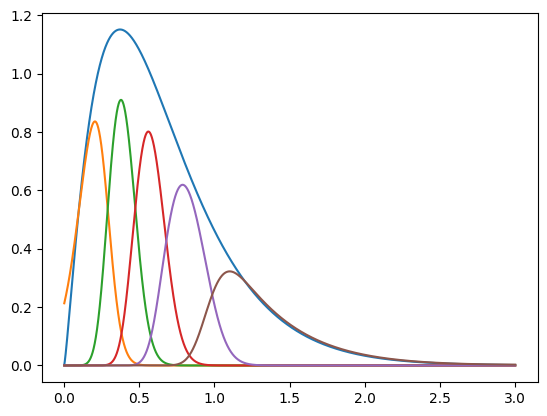

In [51]:
## TEST2: Plots to check binned redshift distribution


plt.plot(z , Rdist)
plt.plot(z ,Binned_distribution[0])
plt.plot(z ,Binned_distribution[1])
plt.plot(z ,Binned_distribution[2])
plt.plot(z ,Binned_distribution[3])
plt.plot(z ,Binned_distribution[4])


## Create mock training data (P(k)) from "simulations"

In [16]:
""" define cosmological parameters """

c = 3e5                                                                  # km/s

for k in range(2):
    for i in range(2):
        for j in range(2):
            if i==0 and j==0 and k==0:
                cosmo_training = ccl.Cosmology(Omega_c = 0.245 + (0.005 * i), 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.90 + 0.05 * j,
                          sigma8 = 0.75 + 0.05 * k)
            else:
                cosmo_training = np.append(cosmo_training, ccl.Cosmology(Omega_c = 0.245 + (0.005 * i), 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 0.90 + 0.05 * j,
                          sigma8 = 0.7 + 0.1 * k))

print(cosmo_training.shape)

(8,)


In [17]:
""" Finding pk_nl and pk_lin for all cosmologies (our training data) - 
for len(z_traindata) redshifts and len(k_traindata) wavevectors"""

# create vector for wavevector k. This will come from simulations
k_traindata = np.logspace(-3,3,50)

# create vector for scale factor a. This will come from simulations
z_traindata = np.linspace(0,3,5)
a_traindata = np.flip(1/(z_traindata + 1))

del z_traindata

for i in range(len(cosmo_training)):
    if i==0:
        pk_lin = [ccl.linear_matter_power(cosmo_training[i], k=k_traindata, a=a_traindata)]
        pk_nl = [ccl.nonlin_matter_power(cosmo_training[i], k=k_traindata, a=a_traindata)]
    else:
        pk_lin = np.append(pk_lin,[ccl.linear_matter_power(cosmo_training[i], k=k_traindata, a=a_traindata)], axis=0)
        pk_nl = np.append(pk_nl,[ccl.nonlin_matter_power(cosmo_training[i], k=k_traindata, a=a_traindata)],axis=0)

print(pk_lin.shape)
print(pk_nl.shape)

(8, 5, 50)
(8, 5, 50)


In [18]:
print(len(pk_lin[0]))

5


## Find mock data vector from "dataset" (C_ell)

In [112]:
def Cell_mockdata(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution):
    """
    Finds C^{i,j}(ell) for {i,j} redshift bins (shape-shape angular power spectrum).
    input:
        redshift z: numpy.array with dim:N
        binned redshift dist: numpy.array with dim:(N,M) (M = no. z bins)
        minimum value of ell: int
        maximum value of ell: int
        number of ell bins: int (value P)
    returns:
        ell bins: numpy.array with dim:P*(M+1)*M/2
        C_ell: numpy.array with dim:P*(M+1)*M/2
    """
    #find ell array
    ell = np.arange(ell_min, ell_max)
    
    # define quantities for binning in ell
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    # Repeat ell_binned over all redshift bins, so that len(ell_binned)=len(C_ell_array)
    ell_binned = list(islice(cycle(ell_binned), int(ell_bin_num*((len(Binned_distribution)+1)*len(Binned_distribution))/2)))
    
    # Find NL power spectrum at given cosmo
    def pk_func(k, a):
        return ccl.nonlin_matter_power(cosmo, k=k, a=a)
    
    P_delta2D = ccl.pk2d.Pk2D.from_function(pkfunc=pk_func, is_logp=False)

    C_ell_array = []
    for j in range(len(Binned_distribution)):
        for k in range(len(Binned_distribution)):
            if k > j:
                break
            tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[j]))
            tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, Binned_distribution[k]))
            C_ell = ccl.angular_cl(cosmo, tracer1, tracer2, ell, p_of_k_a=P_delta2D)        # uses non-linear matter power spectrum stored in `cosmo`

            # bin ell
            bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell, statistic='mean', 
                                                                           bins= ell_binned_limits)
            C_ell_array = np.append(C_ell_array, bin_means)

    return ell_binned, C_ell_array

In [113]:
"""Create mock data vector"""

# define ell and C_ell shapes -- will depend on the data

ell_min_mockdata = 2
ell_max_mockdata = 2060

# define quantities for binning of ell -- will depend on the data

ell_bin_num_mockdata = 18

# Define cosmology -- our "universe cosmology"

cosmo_universe = ccl.Cosmology(Omega_c = 0.26, 
                          Omega_b = 0.05, 
                          h = 0.7, 
                          n_s = 1.05,
                          sigma8 = 0.7)

# find C_ell for non-linear matter power spectrum
mockdata = Cell_mockdata(ell_min_mockdata, ell_max_mockdata, ell_bin_num_mockdata, cosmo_universe, z, Binned_distribution)

ell_mockdata = mockdata[0]
D_mockdata = mockdata[1]

print(D_mockdata.shape)
del mockdata

(270,)


## Get covariance matrix

In [114]:
# for now make our fiducial cosmology = universe cosmology
# we use fiducial cosmo only - assume cov. independent of cosmo

In [115]:
"""Define sacc file - Cl^{ij}(ell) for some ell bins and redshift bins"""
# My redshifts (for now)
src0 = Binned_distribution[0]
src1 = Binned_distribution[1]
src2 = Binned_distribution[2]
src3 = Binned_distribution[3]
src4 = Binned_distribution[4]
z_src = z

ell_bins = ell[:ell_bin_number]

# z binning 

src_bins = [src0, src1, src2, src3, src4]

s = sacc.Sacc()

for i, bin1 in enumerate(src_bins):
    for j, bin2 in enumerate(src_bins):
        if j > i:
            break
        s.add_tracer('NZ', 'src%d'%i, z=z_src, nz=bin1)
        # construct Cl_gM for sacc file
        shearA = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin1), has_shear=True)
        shearB = ccl.WeakLensingTracer(cosmo_universe, dndz=(z_src, bin2), has_shear=True)

        Cl = ccl.angular_cl(cosmo_universe, shearA, shearB, ell_bins) 
        # bin ell

        s.add_ell_cl('galaxy_shear_cl_ee', 'src%d'%i, 
                            'src%d'%j, ell_bins, Cl, tracers_later=True)

s.save_fits('/home/c2042999/PCA_project/Covariance_understanding/cl_and_xi_data.fits', overwrite=True)

In [116]:
s = sacc.Sacc.load_fits("/home/c2042999/PCA_project/Covariance_understanding/cl_and_xi_data.fits")

In [117]:
config = '/home/c2042999/PCA_project/Covariance_understanding/Fourier_cosmic_shear_gauss.yaml'

gauss_calc = CovarianceCalculator(config)

# get matrix
gauss_cov = gauss_calc.get_covariance()

Computing independent covariance blocks
Rank None: ('src0', 'src0'), ('src0', 'src0')


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/tjpcov/covariance_builder.py:887: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Rank None: ('src0', 'src0'), ('src1', 'src0')
Rank None: ('src0', 'src0'), ('src1', 'src1')


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


Rank None: ('src0', 'src0'), ('src2', 'src0')
Rank None: ('src0', 'src0'), ('src2', 'src1')
Rank None: ('src0', 'src0'), ('src2', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src0')
Rank None: ('src0', 'src0'), ('src3', 'src1')
Rank None: ('src0', 'src0'), ('src3', 'src2')
Rank None: ('src0', 'src0'), ('src3', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src0')
Rank None: ('src0', 'src0'), ('src4', 'src1')
Rank None: ('src0', 'src0'), ('src4', 'src2')
Rank None: ('src0', 'src0'), ('src4', 'src3')
Rank None: ('src0', 'src0'), ('src4', 'src4')
Rank None: ('src1', 'src0'), ('src1', 'src0')
Rank None: ('src1', 'src0'), ('src1', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src0')
Rank None: ('src1', 'src0'), ('src2', 'src1')
Rank None: ('src1', 'src0'), ('src2', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src0')
Rank None: ('src1', 'src0'), ('src3', 'src1')
Rank None: ('src1', 'src0'), ('src3', 'src2')
Rank None: ('src1', 'src0'), ('src3', 'src3')
Rank None: ('src1', 'src0'), ('src

(270, 270)


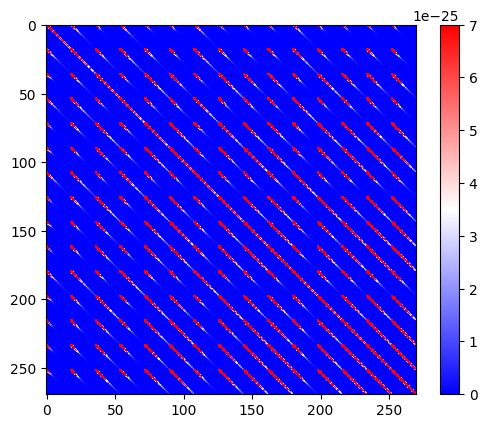

In [118]:
print(gauss_cov.shape)
plt.imshow(gauss_cov, origin='upper',  vmin=0, vmax=7e-25, cmap='bwr')
plt.colorbar()
plt.show()

## Get quantities to put in MCMC step

In [132]:
"""Package quanitites to input into likelihood function"""
P_k_sim_mock = [pk_lin, pk_nl, k_traindata, a_traindata]
C_ell_data_mock = [D_mockdata, ell_mockdata, z, Binned_distribution]
# will also use gauss_cov

"""Define MCMC step"""
cosmo_MCMC = ccl.Cosmology(Omega_c = 0.25, 
                      Omega_b = 0.05,
                      h = 0.7,
                      n_s = 0.95,
                      sigma8 = 0.8)

# Complete MCMC

## Define functions for MCMC -- try with ratio

In [133]:
def findC_ell_array(cosmoMCMCstep, C_ell_data , P_k_sim):
    """
    Find C_ell_training nonlinear for a single MCMC step for the training power spectra
    Pk_nl or _lin: (no training sims, a_arr, k_arr)
    """
    pk_lin, pk_nl, k_arr, a_arr = P_k_sim
    D_datavect, ell_binned, z, Binned_distribution = C_ell_data

    # Define quantities for ell binning
    ell_bin_num = int(len(ell_binned)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))
    ell = ell_binned[0:ell_bin_num]
    
    B_data = np.zeros((len(pk_lin),len(D_datavect)))

    for i in range(len(pk_nl)):
        C_ell_array = []

        # Find P(k) at cosmo of specific MCMC step
        pk_fid = ccl.linear_matter_power(cosmoMCMCstep, k=k_arr, a=a_arr)
        P_delta = (pk_nl[i]/pk_lin[i]) * pk_fid
        P_delta2D = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=P_delta, is_logp=False)
        
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[j]))
                tracer2 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[k]))
                C_ell = ccl.angular_cl(cosmoMCMCstep, tracer1, tracer2, ell, p_of_k_a=P_delta2D)        # uses non-linear matter power spectrum stored in `cosmo`

                C_ell_array = np.append(C_ell_array, C_ell)
        B_data[i] = C_ell_array
    return ell_binned, B_data

In [134]:
def findC_ell_array_linear(cosmoMCMCstep, C_ell_data , P_k_sim):
    """
    Find C_ell_training linear for a single MCMC step for the training power spectra
    Pk_nl or _lin: (no training sims, a_arr, k_arr)
    """
    pk_lin, pk_nl, k_arr, a_arr = P_k_sim
    D_datavect, ell_binned, z, Binned_distribution = C_ell_data

    # Define quantities for ell binning
    ell_bin_num = int(len(ell_binned)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))
    ell = ell_binned[0:int(ell_bin_num)]
    
    B_data = np.zeros((len(pk_lin),len(D_datavect)))

    C_ell_array = []
    
    P_delta = ccl.linear_matter_power(cosmoMCMCstep, k=k_arr, a=a_arr)
    P_delta2D = ccl.pk2d.Pk2D(a_arr=a_arr, lk_arr=np.log(k_arr), pk_arr=P_delta, is_logp=False)
    
    for j in range(len(Binned_distribution)):
        for k in range(len(Binned_distribution)):
            if k > j:
                break
            tracer1 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[j]))
            tracer2 = ccl.WeakLensingTracer(cosmoMCMCstep, dndz=(z, Binned_distribution[k]))
            C_ell = ccl.angular_cl(cosmoMCMCstep, tracer1, tracer2, ell, p_of_k_a=P_delta2D)

            C_ell_array = np.append(C_ell_array, C_ell)
    return ell, C_ell_array

In [135]:
## TEST: FIND M, B_data for example MCMC step
C_ell_data = findC_ell_array(cosmo_MCMC, C_ell_data_mock , P_k_sim_mock)

ell = C_ell_data[0]
B_data = C_ell_data[1]

C_ell_data_lin = findC_ell_array_linear(cosmo_MCMC, C_ell_data_mock , P_k_sim_mock)

M_data = C_ell_data_lin[1]


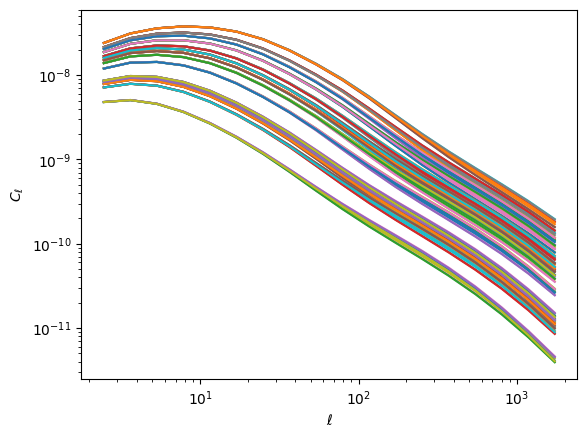

In [136]:
## TEST: Plot C_ell to see if shapes are reasonable

ell_bin_number = int(len(ell)/((len(Binned_distribution)+1)*len(Binned_distribution)/2))

for i in range(len(B_data)):
    for j in range(int(len(B_data[0])/ell_bin_number) - 1):
        plt.plot(ell[j*ell_bin_number:(j+1)*ell_bin_number], B_data[i][j*ell_bin_number:(j+1)*ell_bin_number])


plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xscale('log')
plt.yscale('log')
plt.show()

Text(0, 0.5, '$\\frac{C^{00}_{NL}(\\ell)}{C^{00}_{Linear}(\\ell)} - 1$')

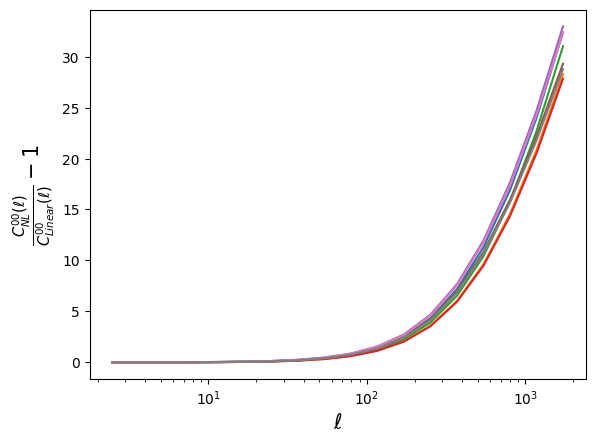

In [137]:
# TEST: Plot processed data to compare with Huang et al 2020

frac = (B_data / M_data) - 1

plt.xscale('log')
#plt.ylim(-0.1,0.5)
#plt.xlim(2,1e2)
for i in range(len(B_data)):
    plt.plot(ell[0:ell_bin_number],frac[i][0:ell_bin_number])

plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$\frac{C^{00}_{NL}(\ell)}{C^{00}_{Linear}(\ell)} - 1$', size = 15)

Text(0, 0.5, '$C^{00}_{NL}(\\ell) - C^{00}_{Linear}(\\ell)$')

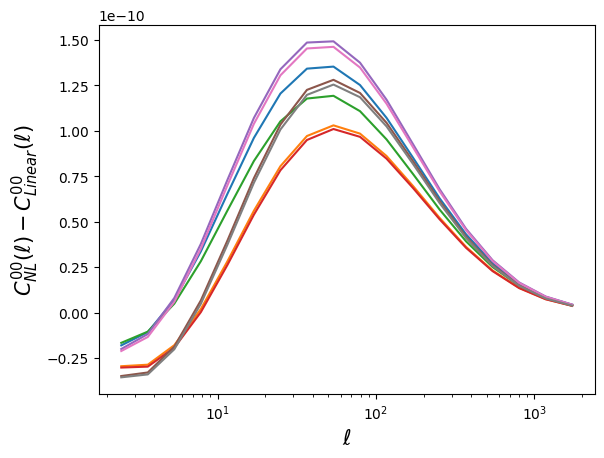

In [138]:
# TEST: Plot processed data to compare with Huang et al 2020

sub = (B_data - M_data) 

plt.xscale('log')
#plt.ylim(0,0.5)
for i in range(len(B_data)):
    plt.plot(ell[0:ell_bin_number],sub[i][0:ell_bin_number])
    
plt.xlabel(r'$\ell$', size = 15)
plt.ylabel(r'$C^{00}_{NL}(\ell) - C^{00}_{Linear}(\ell)$', size = 15)


## Finding PCA components and Likelihood

In [139]:
# Perform PCA with numpy.linalg.svd - find rotation matrix
def findPCA(M_data, B_data):
    Delta = (B_data - M_data)
    Usvd, s, vh = np.linalg.svd(Delta.T, full_matrices=True)
    Usvd = Usvd.T
    return Usvd

In [140]:
# log likelihood - no scale cuts
def loglikelihood_nocut(Data, cosmoMCMCstep, Covmat, P_k_sim):
    D_theory = findC_ell_array_linear(cosmoMCMCstep, Data , P_k_sim)[1]
    D_data, ell_binned, z, Binned_distribution = Data
    Diff = (D_data - D_theory)
    return -0.5*(np.matmul(np.matmul(Diff,np.linalg.inv(Covmat)),Diff))

# log likelihood with cut data
# P_k_sim = P_k_sim_mock
# Data = C_ell_data_mock
# Covmat = gauss_cov
def loglikelihood(Data, cosmoMCMCstep, Covmat, P_k_sim):
    # Get theoretical data vector for single MCMC step
    D_theory = findC_ell_array_linear(cosmoMCMCstep, Data , P_k_sim)[1]
    # Extract real data vector
    D_data, ell_binned, z, Binned_distribution = Data
    # Find difference
    Diff = (D_data - D_theory)
    # EXTRACT PCA MATRIX
    C_ell_data = findC_ell_array(cosmoMCMCstep, Data , P_k_sim)
    B_data = C_ell_data[1]
    C_ell_data_lin = findC_ell_array_linear(cosmoMCMCstep, Data , P_k_sim)
    M_data = C_ell_data_lin[1]
    Usvd = findPCA(M_data, B_data)
    # Cut data vector and cov. matrix
    Diff_cut = np.matmul(Usvd[8:], Diff.T)
    Covmat_cut = np.matmul(np.matmul(Usvd[8:],Covmat), Usvd[8:].T)
    
    return -0.5*(np.matmul(np.matmul(Diff_cut.T,np.linalg.inv(Covmat_cut)),Diff_cut))



## Complete MCMC

In [141]:
start = time.time()

print(loglikelihood(C_ell_data_mock, cosmo_universe, gauss_cov, P_k_sim_mock))
print(loglikelihood(C_ell_data_mock, cosmo_MCMC, gauss_cov, P_k_sim_mock))

print(time.time() - start)

-1881.3586669291064
-1118100.6210985912
1.984971046447754
